In [ ]:
import pandas as pd
from utils.plotting import plot_time, plot_sep, plot_trajectories

**Read results**

In [ ]:
TASK = "income"
STATE = "OK"
DATASET = TASK + "_" + STATE
DATASET = TASK + "_" + STATE
loaded_models = []

experiments_to_read = {
    'SGD': {
        'unconstrained': 0.05
    },
    'SSG': {
        "loss_equality": 0.005
    },
    'SSLALM': {
        "loss_equality": 0.005
    },
    'StochasticGhost': {
        'loss_equality': 0.005
    },
    'TorchSSG': {
        # "abs_max_dev_from_overall_tpr": 0.03,
        "abs_diff_pr": 0.05
    },
    'TorchSSLALM': {
        # "abs_max_dev_from_overall_tpr": 0.03,
        "abs_diff_pr": 0.05
    },
}

In [ ]:
from itertools import product
import os

# names = product(alg_list, constr_list, lb_list)
alg_states = {}
full_eval_train = {}
full_eval_test = {}

for alg, con in experiments_to_read.items():
    for constraint, bound in con.items():
        FILE_EXT = ".pt"
        dir = f"./utils/exp_results/{constraint}"

        filename_state = os.path.join(dir, f"{alg}_" + f"{DATASET}_{bound}.csv")
        filename_full_train = os.path.join(dir, f"AFTER_{alg}_" + f"{DATASET}_{bound}_train.csv")
        filename_full_test = os.path.join(dir, f"AFTER_{alg}_" + f"{DATASET}_{bound}_test.csv")
        try:
            data_state = pd.read_pickle(filename_state).reset_index()
            data_full_train = pd.read_pickle(filename_full_train).reset_index()
            data_full_test = pd.read_pickle(filename_full_test).reset_index()

            alg_states['__'.join([alg, constraint, str(bound)])] = data_state
            full_eval_train['__'.join([alg, constraint, str(bound)])] = data_full_train
            full_eval_test['__'.join([alg, constraint, str(bound)])] = data_full_test

            print(f'loaded {alg} | {constraint} | {bound}')
        except FileNotFoundError: 
            print(f'not found {alg} | {constraint} | {bound} at {dir}')

not found SGD | unconstrained | 0.05 at ./utils/exp_results/unconstrained
loaded SSG | loss_equality | 0.005
loaded SSLALM | loss_equality | 0.005
loaded StochasticGhost | loss_equality | 0.005
not found TorchSSG | abs_diff_pr | 0.05 at ./utils/exp_results/abs_diff_pr
not found TorchSSLALM | abs_diff_pr | 0.05 at ./utils/exp_results/abs_diff_pr


In [ ]:
import numpy as np


def explode_column(df, col, names, m):
    df[names] = list(
        df[col].map(
                    lambda x: [np.nan]*m if np.all(np.isnan(x)) else x 
                    )
        )

def aggregate_stats(live_stats, after_stats, constraint_bound):
    """
    live_stats: states of the algorithm evaluated during run
    after_stats: statistics evaluated on full set after run
    """
    live_stats.columns = live_stats.columns.map(lambda x: str(x) + '_live' if x == 'c' else x)
    after_stats.columns = after_stats.columns.map(lambda x: str(x) + '_full' if x == 'c' else x)
    # combine into one dataframe
    stats_joined = after_stats.set_index(['iteration', 'trial']).join(live_stats.set_index(['iteration', 'trial']), on=['iteration', 'trial'], how='inner',lsuffix='_full', rsuffix='_live')
    for col in stats_joined.columns:
        if col == "time":
            continue
        # change [list] into list
        if isinstance(stats_joined[col].iloc[0], list):
            stats_joined[col] = stats_joined[col].map(lambda x: x[0] if not np.all(np.isnan(x)) else x)
        # "explode" ndarray column into separate columns
        if isinstance(stats_joined[col].iloc[0], np.ndarray):
            if len(stats_joined[col].iloc[0].shape) == 1 and col in ['c_live', 'c_full']:
                m = len(stats_joined[col].iloc[0])
            
                explode_column(stats_joined, col, [f'{col}{i}' for i in range(m)], m)
                for i in range(m):
                    stats_joined[f'{col}{i}_corrected'] = stats_joined[f'{col}{i}'] + constraint_bound

            # add norm for ndarray columns
            stats_joined[f'{col}_norm'] = stats_joined.apply(lambda x: np.linalg.norm(x[col]),axis=1)

    stats_joined.dropna(axis=0, how='all', inplace=True, subset=[x for x in stats_joined.columns if x not in ['cb', 'time', 'constraint_name']])

    # convert one-element ndarrays into floats
    for col in stats_joined.columns:
        if isinstance(stats_joined[col].iloc[0], np.ndarray):
            if stats_joined[col].iloc[0].ndim == 0 or stats_joined[col].iloc[0].ndim == 1 and stats_joined[col].iloc[0].shape[0] == 1:
                stats_joined[col] = stats_joined[col].astype(float)

    stats_joined.reset_index(drop=False, inplace=True)

    return stats_joined


data_train = {}
data_test = {}

for name in full_eval_train.keys():
    print(name)
    data_train[name] = aggregate_stats(alg_states[name][['f', 'c', 'time','iteration','trial']], full_eval_train[name][['f', 'c','iteration','trial']], float(name.split('__')[-1]))
    data_test[name] = aggregate_stats(alg_states[name][['f', 'c', 'time','iteration','trial']], full_eval_test[name][['f', 'c','iteration','trial']], float(name.split('__')[-1]))

SSG__loss_equality__0.005
SSLALM__loss_equality__0.005
StochasticGhost__loss_equality__0.005


---
---
**Plot w.r.t. time**

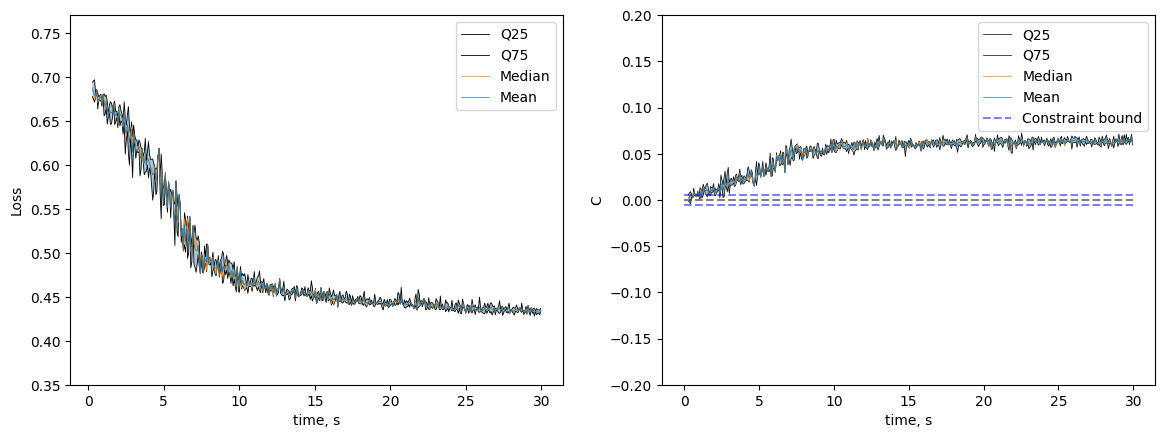

In [ ]:
from utils.plotting import plot_time
from matplotlib import pyplot as plt

# alg_name = "TorchSSLALM"
# c = "abs_diff_pr"
alg_name = "SSG"
c = "loss_equality"
cb = 0.005
alg = f"{alg_name}__{c}__{cb}"

data = data_train[alg]

fl = plot_time(
    data,
    cb,
    loss_col='f_full',
    c_col='c_full1_corrected',
    two_sided=True,
    round_step=0.07,
    f_ylim=(0.35, 0.77),
    c_ylim=(-0.2, 0.2),
    sep_figs=False,
    add_lb=False,
    q1=0.25,
    q2=0.75,
    plot_loss=True
)

---


**Plot trajectories of each run w.r.t. iterations**

In [ ]:
group_names = ['Mar', 'Wid', 'Div', 'Sep', 'Nev']

KeyError: 'SGD__unconstrained__0.005'

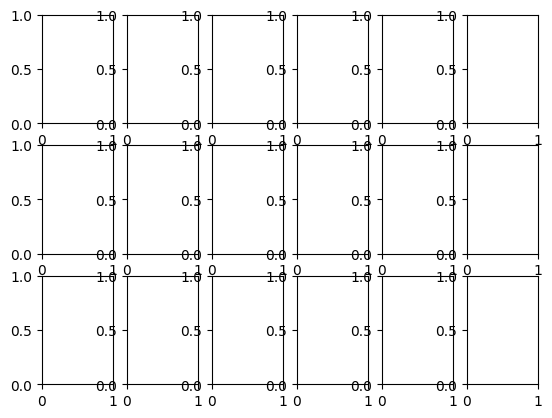

In [ ]:
from utils.plotting import plot_sep, groupby_time
from matplotlib import pyplot as plt

# alg_name = "TorchSSG"
# c = "abs_diff_pr"
alg_name = "SGD"
c = "unconstrained"

colors1 = plt.cm.cividis(np.linspace(0,1, 5))
colors2 = plt.cm.viridis(np.linspace(0, 1, 5))
colors3 = plt.cm.magma(np.linspace(0, 1, 5))

colors = [colors1, colors2, colors3]

f, ax = plt.subplots(3,6)
for n, (alg_name, c) in enumerate([
    ('SGD','unconstrained'),
    ('TorchSSLALM','abs_diff_pr'),
    ('TorchSSG','abs_diff_pr')
    ]):

    alg = f"{alg_name}__{c}__{cb}"
    data = data_train[alg]
    if 'time_r' not in data.columns:
        _ = groupby_time(
            data = data,
            round_step=0.01)
        # data['time_r'] = df['time_r'].mean().to_numpy()
    print(alg)
        

    cb = 0.05
    if isinstance(ax, plt.Axes):
        ax = [ax]
    # ax_f = plot_sep(data, plot_col='f_full', idx_col='trial')
    # ax_f.axes[0].set_ylim(0.4,0.72)
    # ax_f.set_figwidth(20)
    for i in range(6):
        ax = f.axes[i
                    +6*n
                    ]
        if i == 0:
            plot_sep(data, plot_col='f_full', x_col='time_r', idx_col='trial', ax=ax)#, colors=colors[n])
        else:
            plot_sep(data, plot_col=f'c_full{i-1}_corrected', x_col='time_r', idx_col='trial', ax=ax)#, colors=colors[n])
        # ax.set_xticklabels(labels=np.arange())
        ax.set_xticks(np.arange(0, 70, 10))
    f.set_figwidth(30)
    f.set_figheight(15)
    # f.suptitle(alg_name)
    for i in range(6):
        ax = f.axes[i
                    +6*n
                    ]
        if i == 0:
            ax.set_ylim(0.4,0.72)
            ax.patch.set_linewidth(2)
            ax.patch.set_edgecolor('black')
            if n == 0:
                ax.set_title('Loss')
        else:
            ax.hlines((0, cb), 0, ax.get_xbound()[1], ls='--', color='black')
            ax.set_ylim((-0.01, 0.01*30))
            if n == 0:
                ax.set_title(f'Constraint: {group_names[i-1]}')
            else:
                ax.tick_params(bottom=False)

            
# for n, (alg_name, c) in enumerate([
#     ('SGD','unconstrained'),
#     ('TorchSSLALM','abs_diff_pr'),
#     ('TorchSSG','abs_diff_pr')
#     ]):

#     alg = f"{alg_name}__{c}__{cb}"
#     data = data_test[alg]
#     if 'time_r' not in data.columns:
#         _ = groupby_time(
#             data = data,
#             round_step=0.01)
#     cb = 0.05
#     if isinstance(ax, plt.Axes):
#         ax = [ax]
#     for i in range(6):
#         ax = f.axes[i+6*n]
#         if i == 0:
#             plot_sep(data, plot_col='f_full', x_col='time_r', idx_col='trial', ax=ax, alpha=0.5)
#         else:
#             plot_sep(data, plot_col=f'c_full{i-1}_corrected', x_col='time_r', idx_col='trial', ax=ax, alpha=0.5)